# Testing

In [1]:
import sys, os
sys.path.append("../../../")
import setting

from Clust.clust.ML.common.common import p1_integratedDataSaving as p1
from Clust.clust.ML.common.common import p2_dataSelection as p2
from Clust.clust.ML.common.common import p4_testing as p4
from Clust.clust.ML.classification import app
import pathSetting

import torch
#import main_regression as mr
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cpu is available.


## Test Data Preparation

In [2]:
# 1 (p2부분 1. Data Selection)
DataMeta = p1.readJsonData(pathSetting.DataMetaPath)
dataList =  list(DataMeta.keys())

In [3]:
# 1. Select Test Data
# dataX
dataName_X = dataList[2]
# datay
dataName_y = dataList[3]
dataFolderName = "data_integrated_result"

# 2. select Model 
ModelMeta =p1.readJsonData(pathSetting.trainModelMetaFilePath)
modelList = list(ModelMeta.keys())
modelName = modelList[2]

windowNum=128


Start testing data

** Performance of test dataset ==> PROB = [[9.9994290e-01 4.8664770e-05 8.9477989e-09 9.8892281e-07 7.4774603e-06
  1.2441016e-09]
 [2.6572085e-09 1.5521547e-09 4.0106493e-06 4.2574316e-05 4.9790079e-09
  9.9995339e-01]
 [8.4133477e-05 8.1956960e-06 1.8095463e-09 6.5306993e-03 9.9337703e-01
  1.3551176e-08]
 ...
 [1.1953015e-05 9.9989796e-01 9.0153881e-05 6.7046230e-10 7.7676292e-09
  7.8297382e-11]
 [4.3194609e-06 3.2070395e-05 2.7894851e-07 9.9888939e-01 9.8052097e-04
  9.3529714e-05]
 [1.0550969e-04 9.9912685e-01 7.6740870e-04 7.6410771e-08 1.3696960e-07
  5.9345034e-10]], ACC = 0.8036101083032491
** Dimension of result for test dataset = (1385,)
noScale


### Get model meta by mongodb

In [ ]:
from Clust.clust.ingestion.mongo import mongoClient as mongo_client
from Clust.setting import influx_setting_KETI as ins

mongo_client = mongo_client.mongoClient(ins.CLUSTMetaInfo2)

db_name = 'model'
collection_name = 'meta'

all_model_meta = mongo_client.get_all_document(db_name, collection_name)

In [ ]:
db_name = 'model'
collection_name = 'meta'
search = {'modelName': 'EnergyLSTMRegression'}
model_meta= mongo_client.get_document_by_json(db_name, collection_name, search)
model_meta = model_meta[1]

## Testing

In [ ]:
df_result, result_metrics_df, acc= app.get_test_result(dataName_X, dataName_y, modelName, DataMeta, ModelMeta, dataFolderName, device, windowNum, pathSetting.db_client)

{0, 1, 2, 3, 4, 5}

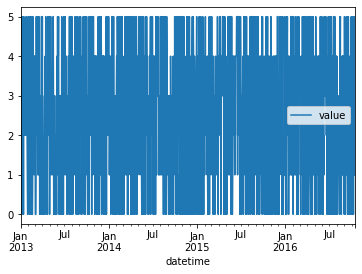

In [4]:
df_result[['value']].plot()

set(df_result['prediction'].values)

In [5]:
result_metrics_df

{'0': {'precision': 0.9203539823008849,
  'recall': 0.8286852589641435,
  'f1-score': 0.8721174004192872,
  'support': 251},
 '1': {'precision': 0.8596491228070176,
  'recall': 0.8789237668161435,
  'f1-score': 0.869179600886918,
  'support': 223},
 '2': {'precision': 0.7185185185185186,
  'recall': 0.9847715736040609,
  'f1-score': 0.8308351177730194,
  'support': 197},
 '3': {'precision': 0.6371308016877637,
  'recall': 0.6622807017543859,
  'f1-score': 0.6494623655913978,
  'support': 228},
 '4': {'precision': 0.719626168224299,
  'recall': 0.6184738955823293,
  'f1-score': 0.6652267818574514,
  'support': 249},
 '5': {'precision': 1.0,
  'recall': 0.8860759493670886,
  'f1-score': 0.9395973154362416,
  'support': 237},
 'accuracy': 0.8036101083032491,
 'macro avg': {'precision': 0.8092130989230806,
  'recall': 0.8098685243480253,
  'f1-score': 0.8044030969940525,
  'support': 1385},
 'weighted avg': {'precision': 0.8127880799742209,
  'recall': 0.8036101083032491,
  'f1-score': 0.8

In [6]:
acc

0.8036101083032491